In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.5


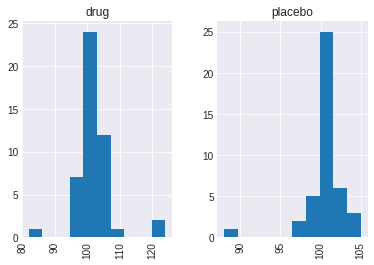

In [2]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group');

In [4]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)

In [5]:
σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

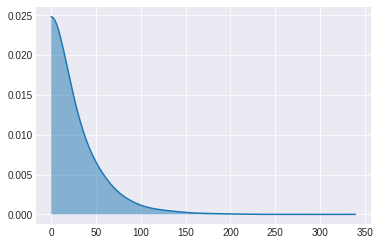

In [6]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), shade=0.5);

In [7]:
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [8]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


In [9]:
with model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1210.96draws/s]


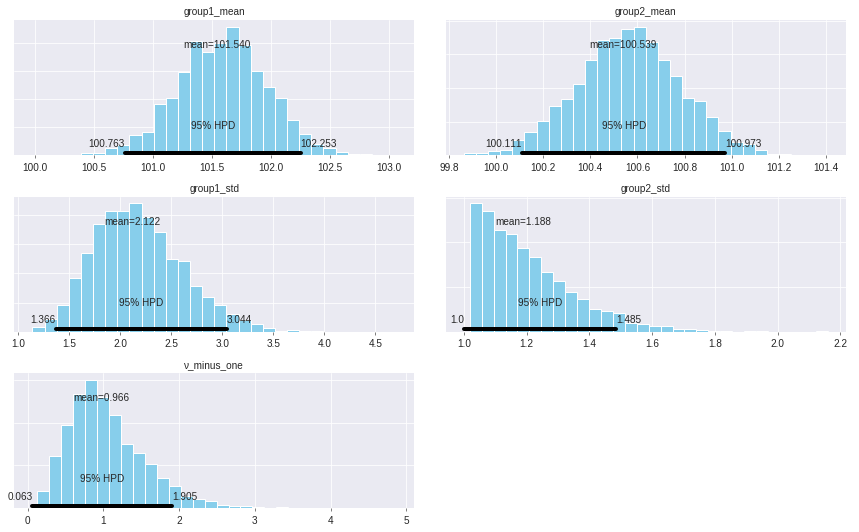

In [10]:
pm.plot_posterior(trace, varnames=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

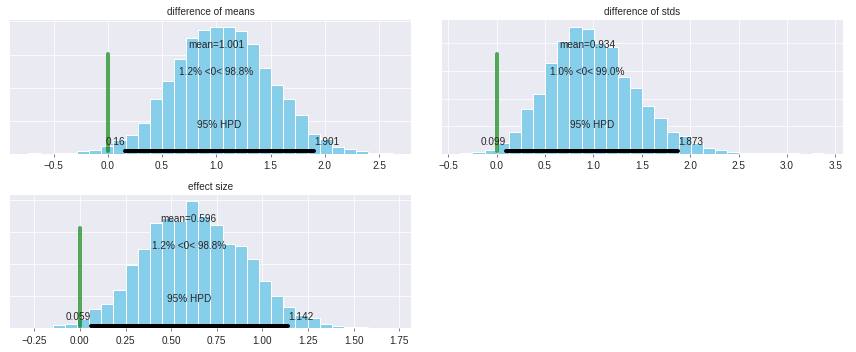

In [11]:
pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

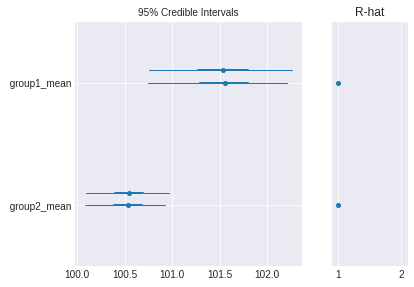

In [12]:
pm.forestplot(trace, varnames=['group1_mean',
                               'group2_mean']);

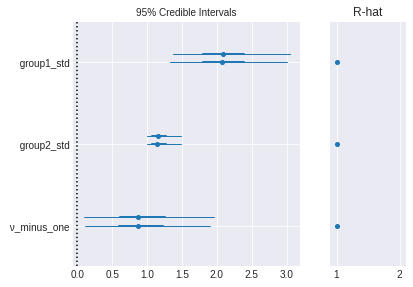

In [13]:
pm.forestplot(trace, varnames=['group1_std',
                               'group2_std',
                               'ν_minus_one']);

In [14]:
pm.summary(trace,varnames=['difference of means', 'difference of stds', 'effect size'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference of means,1.000915,0.443872,0.008012,0.159724,1.900738,3317.781769,1.000345
difference of stds,0.933775,0.457296,0.008188,0.099419,1.872661,3382.365124,0.999750
effect size,0.596487,0.279099,0.004863,0.058995,1.142397,3330.293370,1.000283
